# Shift Rating  
* Evaluate which players can "beat the shift"  
* Compare players' hitting ability when the infield or outfield is shifted vs. in a standard alignment
* Start with shifted average
* Compute rating by finding how far above the average shift average they are

In [90]:
from pybaseball import statcast
import pandas as pd
import matplotlib.pyplot as plt
from pybaseball import playerid_lookup
import numpy as np
from pybaseball import statcast_batter
from pybaseball.lahman import *

In [91]:
#statcast(start_dt='2018-03-29', end_dt='2018-09-30').to_csv(path_or_buf='/Users/Joe/Documents/Baseball/statcast_2018.txt')
#statcast(start_dt='2016-04-01', end_dt='2016-09-30').to_csv(path_or_buf='/Users/Joe/Documents/Baseball/statcast_2016.txt')


In [92]:
stats = pd.read_csv('/Users/Joe/Documents/Baseball/statcast_2016.csv')

In [93]:
stats = stats.loc[stats['events'].notnull()].copy()

In [94]:
#list(stats)

In [95]:
#Get our initial two dataframes of any sort of shifted alignment and all standard alignment
stats = stats.dropna(subset=['if_fielding_alignment', 'of_fielding_alignment'])
stats_shift = stats.loc[(stats['if_fielding_alignment'] != 'Standard') | (stats['of_fielding_alignment'] != 'Standard')]
stats_standard = stats.loc[(stats['if_fielding_alignment'] == 'Standard') & (stats['of_fielding_alignment'] == 'Standard')]

In [96]:
#Separate these into early, mid, and late season
shift_early = stats_shift.loc[stats_shift['game_date'].str.contains('2016-04') | stats_shift['game_date'].str.contains('2016-05')]
shift_mid = stats_shift.loc[stats['game_date'].str.contains('2016-06') | stats_shift['game_date'].str.contains('2016-07')]
shift_late = stats_shift.loc[stats['game_date'].str.contains('2016-08') | stats_shift['game_date'].str.contains('2016-09')]


In [97]:
#Separate standard into early, mid, and late season as well
standard_early = stats_standard.loc[stats_standard['game_date'].str.contains('2016-04') | stats_standard['game_date'].str.contains('2016-05')]
standard_mid = stats_standard.loc[stats['game_date'].str.contains('2016-06') | stats_standard['game_date'].str.contains('2016-07')]
standard_late = stats_standard.loc[stats['game_date'].str.contains('2016-08') | stats_standard['game_date'].str.contains('2016-09')]


In [98]:
#We want dataframes for all the hit events and all the at-bat events so we can eventually calculate an average
#Slight caveat though. I am including sac fly as a 'hit' because I believe if you move a runner up or score a run
#on a sacrifice fly you still did your job, and thus beat the shift.
#I don't believe the same applies to a sac bunt since bunts have virtually no chance of leaving the infield regardless of shift
shift_early_hits = shift_early.loc[(shift_early['events'] == 'single') | (shift_early['events'] == 'double') | (shift_early['events'] == 'triple') | (shift_early['events'] == 'home_run') | (shift_early['events'] == 'sac_fly')]
shift_mid_hits = shift_mid.loc[(shift_mid['events'] == 'single') | (shift_mid['events'] == 'double') | (shift_mid['events'] == 'triple') | (shift_mid['events'] == 'home_run') | (shift_mid['events'] == 'sac_fly')]
shift_late_hits = shift_late.loc[(shift_late['events'] == 'single') | (shift_late['events'] == 'double') | (shift_late['events'] == 'triple') | (shift_late['events'] == 'home_run') | (shift_late['events'] == 'sac_fly')]

shift_early_ab = shift_early.loc[(shift_early['events'] == 'field_out') | (shift_early['events'] == 'strikeout') | (shift_early['events'] == 'single') | (shift_early['events'] == 'double') | (shift_early['events'] == 'grounded_into_double_play') | (shift_early['events'] == 'home_run') | (shift_early['events'] == 'double_play') | (shift_early['events'] == 'triple') | (shift_early['events'] == 'sac_fly') | (shift_early['events'] == 'force_out') | (shift_early['events'] == 'field_error') | (shift_early['events'] == 'fielders_choice_out') | (shift_early['events'] == 'strikeout_double_play') | (shift_early['events'] == 'sac_fly_double_play') | (shift_early['events'] == 'fielders_chocie') | (shift_early['events'] == 'other_out') | (shift_early['events'] == 'triple_play')]
shift_mid_ab = shift_mid.loc[(shift_mid['events'] == 'field_out') | (shift_mid['events'] == 'strikeout') | (shift_mid['events'] == 'single') | (shift_mid['events'] == 'double') | (shift_mid['events'] == 'grounded_into_double_play') | (shift_mid['events'] == 'home_run') | (shift_mid['events'] == 'double_play') | (shift_mid['events'] == 'triple') | (shift_mid['events'] == 'sac_fly') | (shift_mid['events'] == 'force_out') | (shift_mid['events'] == 'field_error') | (shift_mid['events'] == 'fielders_choice_out') | (shift_mid['events'] == 'strikeout_double_play') | (shift_mid['events'] == 'sac_fly_double_play') | (shift_mid['events'] == 'fielders_chocie') | (shift_mid['events'] == 'other_out') | (shift_mid['events'] == 'triple_play')]
shift_late_ab = shift_late.loc[(shift_late['events'] == 'field_out') | (shift_late['events'] == 'strikeout') | (shift_late['events'] == 'single') | (shift_late['events'] == 'double') | (shift_late['events'] == 'grounded_into_double_play') | (shift_late['events'] == 'home_run') | (shift_late['events'] == 'double_play') | (shift_late['events'] == 'triple') | (shift_late['events'] == 'sac_fly') | (shift_late['events'] == 'force_out') | (shift_late['events'] == 'field_error') | (shift_late['events'] == 'fielders_choice_out') | (shift_late['events'] == 'strikeout_double_play') | (shift_late['events'] == 'sac_fly_double_play') | (shift_late['events'] == 'fielders_chocie') | (shift_late['events'] == 'other_out') | (shift_late['events'] == 'triple_play')]


In [99]:
#These are the same slices as above but for our standard alignment
standard_early_hits = standard_early.loc[(standard_early['events'] == 'single') | (standard_early['events'] == 'double') | (standard_early['events'] == 'triple') | (standard_early['events'] == 'home_run') | (standard_early['events'] == 'sac_fly')]
standard_mid_hits = standard_mid.loc[(standard_mid['events'] == 'single') | (standard_mid['events'] == 'double') | (standard_mid['events'] == 'triple') | (standard_mid['events'] == 'home_run') | (standard_mid['events'] == 'sac_fly')]
standard_late_hits = standard_late.loc[(standard_late['events'] == 'single') | (standard_late['events'] == 'double') | (standard_late['events'] == 'triple') | (standard_late['events'] == 'home_run') | (standard_late['events'] == 'sac_fly')]

standard_early_ab = standard_early.loc[(standard_early['events'] == 'field_out') | (standard_early['events'] == 'strikeout') | (standard_early['events'] == 'single') | (standard_early['events'] == 'double') | (standard_early['events'] == 'grounded_into_double_play') | (standard_early['events'] == 'home_run') | (standard_early['events'] == 'double_play') | (standard_early['events'] == 'triple') | (standard_early['events'] == 'sac_fly') | (standard_early['events'] == 'force_out') | (standard_early['events'] == 'field_error') | (standard_early['events'] == 'fielders_choice_out') | (standard_early['events'] == 'strikeout_double_play') | (standard_early['events'] == 'sac_fly_double_play') | (standard_early['events'] == 'fielders_chocie') | (standard_early['events'] == 'other_out') | (standard_early['events'] == 'triple_play')]
standard_mid_ab = standard_mid.loc[(standard_mid['events'] == 'field_out') | (standard_mid['events'] == 'strikeout') | (standard_mid['events'] == 'single') | (standard_mid['events'] == 'double') | (standard_mid['events'] == 'grounded_into_double_play') | (standard_mid['events'] == 'home_run') | (standard_mid['events'] == 'double_play') | (standard_mid['events'] == 'triple') | (standard_mid['events'] == 'sac_fly') | (standard_mid['events'] == 'force_out') | (standard_mid['events'] == 'field_error') | (standard_mid['events'] == 'fielders_choice_out') | (standard_mid['events'] == 'strikeout_double_play') | (standard_mid['events'] == 'sac_fly_double_play') | (standard_mid['events'] == 'fielders_chocie') | (standard_mid['events'] == 'other_out') | (standard_mid['events'] == 'triple_play')]
standard_late_ab = standard_late.loc[(standard_late['events'] == 'field_out') | (standard_late['events'] == 'strikeout') | (standard_late['events'] == 'single') | (standard_late['events'] == 'double') | (standard_late['events'] == 'grounded_into_double_play') | (standard_late['events'] == 'home_run') | (standard_late['events'] == 'double_play') | (standard_late['events'] == 'triple') | (standard_late['events'] == 'sac_fly') | (standard_late['events'] == 'force_out') | (standard_late['events'] == 'field_error') | (standard_late['events'] == 'fielders_choice_out') | (standard_late['events'] == 'strikeout_double_play') | (standard_late['events'] == 'sac_fly_double_play') | (standard_late['events'] == 'fielders_chocie') | (standard_late['events'] == 'other_out') | (standard_late['events'] == 'triple_play')]


In [100]:
#For the sake of typing I'm going to abbreviate 'shift early hits' to 'seh', 'shift mid hits' to 'smh' and so on.
#This will give us the number of hits each batter got when the shift was on.
seh_group = shift_early_hits.groupby(['batter']).size()
smh_group = shift_mid_hits.groupby(['batter']).size()
slh_group = shift_late_hits.groupby(['batter']).size()

#This will give us the number of plate appearances each batter got when the shift was on.
#We'll use 'se_ab' to stand for 'shift early at bat' and same convention for mid and late.
se_ab_group = shift_early_ab.groupby(['batter']).size()
sm_ab_group = shift_mid_ab.groupby(['batter']).size()
sl_ab_group = shift_late_ab.groupby(['batter']).size()

In [101]:
#For the non-shift situations I will use the abbreviation 'stan_eh' to mean 'standard early hits.' Not the 
#most concise but it gets the job done.
#This will give the number of hits each batter had without any shift on.
stan_eh_group = standard_early_hits.groupby(['batter']).size()
stan_mh_group = standard_mid_hits.groupby(['batter']).size()
stan_lh_group = standard_late_hits.groupby(['batter']).size()

#Now we will find the number of at bats each batter had without a shift one.
#Here I will use 'stan_eab' to mean 'standard early at bat' and so on.
stan_eab_group = standard_early_ab.groupby(['batter']).size()
stan_mab_group = standard_mid_ab.groupby(['batter']).size()
stan_lab_group = standard_late_ab.groupby(['batter']).size()

In [102]:
#Let's turn them all into dictionaries so we can actually do things with them
seh_group = seh_group.to_dict()
smh_group = smh_group.to_dict()
slh_group = slh_group.to_dict()
se_ab_group = se_ab_group.to_dict()
sm_ab_group = sm_ab_group.to_dict()
sl_ab_group = sl_ab_group.to_dict()

stan_eh_group = stan_eh_group.to_dict()
stan_mh_group = stan_mh_group.to_dict()
stan_lh_group = stan_lh_group.to_dict()
stan_eab_group = stan_eab_group.to_dict()
stan_mab_group = stan_mab_group.to_dict()
stan_lab_group = stan_lab_group.to_dict()

In [103]:
batting = batting()
player_data = master()
bat_names = pd.merge(batting, player_data[['playerID','nameFirst', 'nameLast']], on='playerID', how='inner')
bat_names = bat_names.loc[bat_names['yearID'] == 2016]

In [195]:
pd.set_option('expand_frame_repr', True)

In [213]:
'''
This function takes in a players first and last name and then returns the following:
* early season shift average
* early season standard alignment average
* mid season shift average
* mid season standard alignment average
* late season shift average
* late season standard alignment average

If 'verbose' is set to True, then the function will also print all of these 
values in a nice format.
'''
def player_shift(last_name, first_name, verbose = False):
    id_num = playerid_lookup(last_name, first_name)['key_mlbam']
    print()

    first_letter = first_name[0].capitalize()
    last_letter = last_name[0].capitalize()
    
    first_name = first_letter + first_name[1:]
    last_name = last_letter + last_name[1:]
    
    player_bat = bat_names.loc[(bat_names['nameFirst'] == first_name) & (bat_names['nameLast'] == last_name)].copy()
    player_bat['ba'] = player_bat['H'] / player_bat['AB']
    player_bat['obp'] = (player_bat['H'] + player_bat['BB'] + player_bat['HBP']) / (player_bat['AB'] + player_bat['BB'] + player_bat['HBP'] + player_bat['SF'])
    ba = str(round(player_bat['ba'].iloc[0], 3))
    obp = str(round(player_bat['obp'].iloc[0], 3))
    
    
    if len(id_num) == 0:
        return "Not a valid player name."
    id_num = int(id_num)
    
    if id_num in se_ab_group:
        if id_num in seh_group:
            early_shift_avg = seh_group[id_num] / se_ab_group[id_num]
        else:
            early_shift_avg = 0
    if id_num in sm_ab_group:
        if id_num in smh_group:
            mid_shift_avg = smh_group[id_num] / sm_ab_group[id_num]
        else:
            mid_shift_avg = 0
    if id_num in sl_ab_group:
        if id_num in slh_group:
            late_shift_avg = slh_group[id_num] / sl_ab_group[id_num]
        else:
            late_shift_avg = 0
            
    if id_num in stan_eab_group:
        if id_num in stan_eh_group:
            early_stan_avg = stan_eh_group[id_num] / stan_eab_group[id_num]
        else:
            early_stan_avg = 0
    if id_num in stan_mab_group:
        if id_num in stan_mh_group:
            mid_stan_avg = stan_mh_group[id_num] / stan_mab_group[id_num]
        else:
            mid_stan_avg = 0
    if id_num in stan_lab_group:
        if id_num in stan_lh_group:
            late_stan_avg = stan_lh_group[id_num] / stan_lab_group[id_num]
        else:
            late_stan_avg = 0
            
    tot_shift = se_ab_group[id_num] + sm_ab_group[id_num] + sl_ab_group[id_num]
    percent_shift = (tot_shift / (tot_shift + stan_eab_group[id_num] + stan_mab_group[id_num] + stan_lab_group[id_num])) * 100
    
    player_list = [[first_name, last_name, str(round(early_shift_avg, 3)), str(round(early_stan_avg, 3)), str(round(mid_shift_avg, 3)), str(round(mid_stan_avg, 3)), str(round(late_shift_avg, 3)), str(round(late_stan_avg, 3)), str(ba), str(obp), str(round(percent_shift, 3))]]
    player_df = pd.DataFrame(np.array(player_list))
    player_df.columns = ['first_name', 'last_name', 'early_shift_avg', 'early_stan_avg', 'mid_shift_avg', 'mid_stan_avg', 'late_shift_avg', 'late_stan_avg', 'total_avg', 'total_obp', 'percent_ab_shifted']
    print(player_df)
    
    if verbose == True:
        print(first_name + " " + last_name + " early shift average: {:.3f}".format(early_shift_avg))
        print(first_name + " " + last_name + " early standard average: {:.3f}".format(early_stan_avg))
        print()
        print(first_name + " " + last_name + " mid shift average: {:.3f}".format(mid_shift_avg))
        print(first_name + " " + last_name + " mid standard average: {:.3f}".format(mid_stan_avg))
        print()
        print(first_name + " " + last_name + " late shift average: {:.3f}".format(late_shift_avg))
        print(first_name + " " + last_name + " late standard average: {:.3f}".format(late_stan_avg))
        
    y = [early_shift_avg, early_stan_avg, mid_shift_avg, mid_stan_avg, late_shift_avg, late_stan_avg]
    y1 = [y[0], y[2], y[4]]
    y2 = [y[1], y[3], y[5]]
    x = ['early', 'mid', 'late']

    fig,ax = plt.subplots(figsize=(8,6))
    plt.scatter(x, y1, label="Shift")
    plt.scatter(x, y2, label="Standard")
    plt.title(first_name + " " + last_name + " Average w/ Shift vs. Standard Alignment")
    plt.xlabel("Time of Season")
    plt.ylabel("Average")
    plt.legend()
    plt.show()
    
    return early_shift_avg, early_stan_avg, mid_shift_avg, mid_stan_avg, late_shift_avg, late_stan_avg

Gathering player lookup table. This may take a moment.

  first_name last_name early_shift_avg early_stan_avg mid_shift_avg  \
0     Mookie     Betts           0.366          0.264         0.333   

  mid_stan_avg late_shift_avg late_stan_avg total_avg total_obp  \
0        0.337          0.438         0.346     0.318     0.363   

  percent_ab_shifted  
0             11.872  


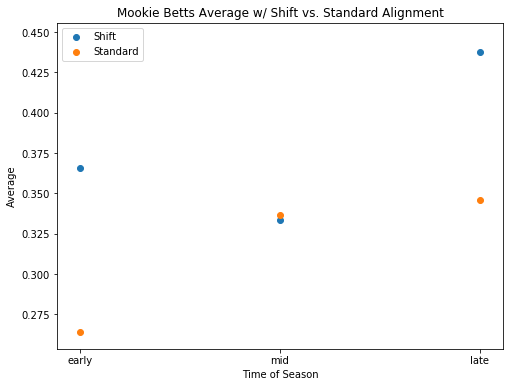

(0.36585365853658536,
 0.2640449438202247,
 0.3333333333333333,
 0.3368421052631579,
 0.4375,
 0.3459715639810427)

In [214]:
player_shift("betts", "mookie")

In [106]:
#We want to turn the shift average into a rating, with 100 as the average player
#To do this we need to find the league average shift average in 2018
#Below we simply finding the at bats and hits for the whole season instead of early, mid, late
stats_shift_h = stats_shift.loc[(stats_shift['events'] == 'single') | (stats_shift['events'] == 'double') | (stats_shift['events'] == 'triple') | (stats_shift['events'] == 'home_run') | (stats_shift['events'] == 'sac_fly')]
stats_shift_ab = stats_shift.loc[(stats_shift['events'] == 'field_out') | (stats_shift['events'] == 'strikeout') | (stats_shift['events'] == 'single') | (stats_shift['events'] == 'double') | (stats_shift['events'] == 'grounded_into_double_play') | (stats_shift['events'] == 'home_run') | (stats_shift['events'] == 'double_play') | (stats_shift['events'] == 'triple') | (stats_shift['events'] == 'sac_fly') | (stats_shift['events'] == 'force_out') | (stats_shift['events'] == 'field_error') | (stats_shift['events'] == 'fielders_choice_out') | (stats_shift['events'] == 'strikeout_double_play') | (stats_shift['events'] == 'sac_fly_double_play') | (stats_shift['events'] == 'fielders_chocie') | (stats_shift['events'] == 'other_out') | (stats_shift['events'] == 'triple_play')]

In [107]:
#We are doing the same slice as above but with standard fielding alignment
stats_standard_h = stats_standard.loc[(stats_standard['events'] == 'single') | (stats_standard['events'] == 'double') | (stats_standard['events'] == 'triple') | (stats_standard['events'] == 'home_run') | (stats_standard['events'] == 'sac_fly')]
stats_standard_ab = stats_standard.loc[(stats_standard['events'] == 'field_out') | (stats_standard['events'] == 'strikeout') | (stats_standard['events'] == 'single') | (stats_standard['events'] == 'double') | (stats_standard['events'] == 'grounded_into_double_play') | (stats_standard['events'] == 'home_run') | (stats_standard['events'] == 'double_play') | (stats_standard['events'] == 'triple') | (stats_standard['events'] == 'sac_fly') | (stats_standard['events'] == 'force_out') | (stats_standard['events'] == 'field_error') | (stats_standard['events'] == 'fielders_choice_out') | (stats_standard['events'] == 'strikeout_double_play') | (stats_standard['events'] == 'sac_fly_double_play') | (stats_standard['events'] == 'fielders_chocie') | (stats_standard['events'] == 'other_out') | (stats_standard['events'] == 'triple_play')]

In [108]:
#Below we turn our slices into dataframes and then merge them so we have hits and at bats in one
#frame so we can calculate average as another column

shift_h_group = stats_shift_h.groupby(['batter']).size()
shift_h = shift_h_group.to_frame()
shift_h.columns = ['h']

shift_ab_group = stats_shift_ab.groupby(['batter']).size()
shift_ab = shift_ab_group.to_frame()
shift_ab.columns = ['ab']

shift = shift_h.join(shift_ab, how='inner')

shift['avg'] = shift['h'] / shift['ab']

In [109]:
#Same as above but with standard fielding alignment
standard_h_group = stats_standard_h.groupby(['batter']).size()
standard_h = standard_h_group.to_frame()
standard_h.columns = ['h']

standard_ab_group = stats_standard_ab.groupby(['batter']).size()
standard_ab = standard_ab_group.to_frame()
standard_ab.columns = ['ab']

standard = standard_h.join(standard_ab, how='inner')

standard['avg'] = standard['h'] / standard['ab']

In [110]:
#This is the league wide mean value for average with both type of fielding alignment
shift_mean = shift['avg'].mean()
stan_mean = standard['avg'].mean()

In [111]:
#To create a rating, we need to find how much of an increase in average relates to a one point increase in rating
shift_point = shift_mean / 100
stan_point = stan_mean / 100

In [259]:
#We can now use the above calculated values to assign each batter a shift rating where 100 is league average.
shift['shift_rating'] = round(((shift['avg'] - shift_mean) / shift_point) + 100, 0)
standard['stan_rating'] = round(((standard['avg'] - stan_mean) / stan_point) + 100, 0)

shift = shift.sort_values(by=['shift_rating'], ascending=False)
standard = standard.sort_values(by=['stan_rating'], ascending=False)

shift_active = shift.loc[shift['ab'] > 100]
standard_active = standard.loc[standard['ab'] > 100]

good_id = int(shift_active[shift_active['shift_rating'] == shift_active['shift_rating'].max()].index[0])
good_id

502517

In [260]:
#All of the calculations performed above for the entire season are now applied to our early, mid, and late season frames
#'seh' stands for 'shift early hits'
#'se_ab' stands for 'shift early at bats'
#The convention continues like that

seh = pd.DataFrame.from_dict(seh_group, orient='index')
seh.columns = ['h']
smh = pd.DataFrame.from_dict(smh_group, orient='index')
smh.columns = ['h']
slh = pd.DataFrame.from_dict(slh_group, orient='index')
slh.columns = ['h']

se_ab = pd.DataFrame.from_dict(se_ab_group, orient='index')
se_ab.columns = ['ab']
sm_ab = pd.DataFrame.from_dict(sm_ab_group, orient='index')
sm_ab.columns = ['ab']
sl_ab = pd.DataFrame.from_dict(sl_ab_group, orient='index')
sl_ab.columns = ['ab']

se_avg = seh.join(se_ab, how='inner')
sm_avg = smh.join(sm_ab, how='inner')
sl_avg = slh.join(sl_ab, how='inner')

In [261]:
#Same as above but for standard alignment
#'stan_eh' stands for 'standard early hits'
#'stan_eab' stands for 'standard early at bats'
#The convention continues like that

stan_eh = pd.DataFrame.from_dict(stan_eh_group, orient='index')
stan_eh.columns = ['h']
stan_mh = pd.DataFrame.from_dict(stan_mh_group, orient='index')
stan_mh.columns = ['h']
stan_lh = pd.DataFrame.from_dict(stan_lh_group, orient='index')
stan_lh.columns = ['h']

stan_eab = pd.DataFrame.from_dict(stan_eab_group, orient='index')
stan_eab.columns = ['ab']
stan_mab = pd.DataFrame.from_dict(stan_mab_group, orient='index')
stan_mab.columns = ['ab']
stan_lab = pd.DataFrame.from_dict(stan_lab_group, orient='index')
stan_lab.columns = ['ab']

stan_e_avg = stan_eh.join(stan_eab, how='inner')
stan_m_avg = stan_mh.join(stan_mab, how='inner')
stan_l_avg = stan_lh.join(stan_lab, how='inner')

In [262]:
se_avg['avg'] = se_avg['h'] / se_avg['ab']
sm_avg['avg'] = sm_avg['h'] / sm_avg['ab']
sl_avg['avg'] = sl_avg['h'] / sl_avg['ab']
stan_e_avg['avg'] = stan_e_avg['h'] / stan_e_avg['ab']
stan_m_avg['avg'] = stan_m_avg['h'] / stan_m_avg['ab']
stan_l_avg['avg'] = stan_l_avg['h'] / stan_l_avg['ab']

#shift['shift_rating'] = round(((shift['avg'] - shift_mean) / shift_point) + 100, 0)
#standard['stan_rating'] = round(((standard['avg'] - stan_mean) / stan_point) + 100, 0)

se_avg['shift_rating'] = round(((se_avg['avg'] - shift_mean) / shift_point) + 100, 0)
sm_avg['shift_rating'] = round(((sm_avg['avg'] - shift_mean) / shift_point) + 100, 0)
sl_avg['shift_rating'] = round(((sl_avg['avg'] - shift_mean) / shift_point) + 100, 0)

stan_e_avg['stan_rating'] = round(((stan_e_avg['avg'] - stan_mean) / stan_point) + 100, 0)
stan_m_avg['stan_rating'] = round(((stan_m_avg['avg'] - stan_mean) / stan_point) + 100, 0)
stan_l_avg['stan_rating'] = round(((stan_l_avg['avg'] - stan_mean) / stan_point) + 100, 0)

In [263]:
#Nowe we can create sorted lists by shift rating and standard alignment rating for each player
#during early, mid, and late season

se_avg = se_avg.sort_values(by=['shift_rating'], ascending=False)
sm_avg = sm_avg.sort_values(by=['shift_rating'], ascending=False)
sl_avg = sl_avg.sort_values(by=['shift_rating'], ascending=False)

stan_e_avg = stan_e_avg.sort_values(by=['stan_rating'], ascending=False)
stan_m_avg = stan_m_avg.sort_values(by=['stan_rating'], ascending=False)
stan_l_avg = stan_l_avg.sort_values(by=['stan_rating'], ascending=False)

In [264]:
#Now let's try to make a list of the best 'shift beaters'

se_active = se_avg.loc[se_avg['ab'] >= 75].copy()
sm_active = sm_avg.loc[sm_avg['ab'] >= 75].copy()
sl_active = sl_avg.loc[sl_avg['ab'] >= 75].copy()

In [265]:
se_top5 = se_active.head(5).copy()
sm_top5 = sm_active.head(5).copy()
sl_top5 = sl_active.head(5).copy()

In [266]:
#This gives us a list of the players identified by their playerid....pretty useless unless you have all id's memorized.
#It's pretty easy to find a player id given a name using pybaseball, but it's hard to go the other way.
#Luckily someone made a playerid map that will come in handy.

se_top5['player_name'] = ['Victor Martinez', 'Carlos Gonzalez', 'David Ortiz', 'Jackie Bradley Jr.', 'Carlos Beltran']
sm_top5['player_name'] = ['Joey Votto', 'Carlos Beltran', 'Brandon Moss', 'Kris Bryant', 'Anthony Rizzo']
sl_top5['player_name'] = ['Joey Votto', 'David Ortiz', 'Kris Bryant', 'Freddie Freeman', 'Edwin Encarnacion']

In [267]:
print("Early Season Shift Leaders")
se_top5

Early Season Shift Leaders


,h,ab,avg,shift_rating,player_name
400121.0,42,120,0.350000,124.0,Victor Martinez
471865.0,44,126,0.349206,124.0,Carlos Gonzalez
120074.0,56,163,0.343558,122.0,David Ortiz
598265.0,31,91,0.340659,121.0,Jackie Bradley Jr.
136860.0,35,109,0.321101,114.0,Carlos Beltran


In [268]:
print("Mid Season Shift Leaders")
sm_top5

Mid Season Shift Leaders


,h,ab,avg,shift_rating,player_name
458015.0,34,86,0.395349,140.0,Joey Votto
136860.0,36,98,0.367347,130.0,Carlos Beltran
461235.0,28,84,0.333333,118.0,Brandon Moss
592178.0,35,105,0.333333,118.0,Kris Bryant
519203.0,44,134,0.328358,117.0,Anthony Rizzo


In [269]:
print("Late Season Shift Leaders")
sl_top5

Late Season Shift Leaders


,h,ab,avg,shift_rating,player_name
458015.0,40,99,0.404040,143.0,Joey Votto
120074.0,54,171,0.315789,112.0,David Ortiz
592178.0,26,84,0.309524,110.0,Kris Bryant
518692.0,42,135,0.311111,110.0,Freddie Freeman
429665.0,36,122,0.295082,105.0,Edwin Encarnacion


## Player Charting Function!  
I made a function that will look up any individual player based on their first and last name and print their shifted and standard averages at each point in the season. It will also show the player's total batting average and on base percentage, as well as what percentage of their at bats that season had a shift on.  
If verbose is set to True, then it will print these things in a different format.  
Along with the numbers we also see a graph that prints their shifted vs. standard average at each point in the season.  
The call to the function looks like this:  
`player_shift("last_name", "first_name", verbose=False)`  

Try it out!

Gathering player lookup table. This may take a moment.

  first_name last_name early_shift_avg early_stan_avg mid_shift_avg  \
0     Mookie     Betts           0.366          0.264         0.333   

  mid_stan_avg late_shift_avg late_stan_avg total_avg total_obp  \
0        0.337          0.438         0.346     0.318     0.363   

  percent_ab_shifted  
0             11.872  
Mookie Betts early shift average: 0.366
Mookie Betts early standard average: 0.264

Mookie Betts mid shift average: 0.333
Mookie Betts mid standard average: 0.337

Mookie Betts late shift average: 0.438
Mookie Betts late standard average: 0.346


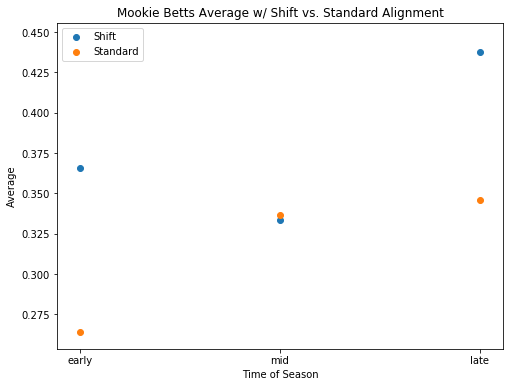

(0.36585365853658536,
 0.2640449438202247,
 0.3333333333333333,
 0.3368421052631579,
 0.4375,
 0.3459715639810427)

In [319]:
player_shift("betts", "mookie", verbose=True)

In [271]:
se_active['id'] = se_active.index
sm_active['id'] = sm_active.index
sl_active['id'] = sl_active.index

se_graph = se_active.loc[se_active['id'] > 300000.0]
sm_graph = sm_active.loc[sm_active['id'] > 300000.0]
sl_graph = sl_active.loc[sl_active['id'] > 300000.0]

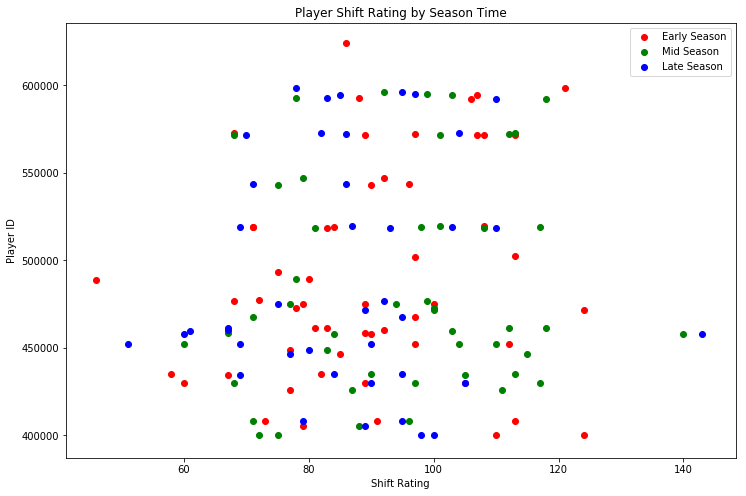

In [272]:
player_early = list(se_graph['id'])
shift_early = list(se_graph['shift_rating'])
player_mid = list(sm_graph['id'])
shift_mid = list(sm_graph['shift_rating'])
player_late = list(sl_graph['id'])
shift_late = list(sl_graph['shift_rating'])

fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(shift_early, player_early, color='red', label='Early Season')
plt.scatter(shift_mid, player_mid, color='green', label='Mid Season')
plt.scatter(shift_late, player_late, color='blue', label='Late Season')
plt.title("Player Shift Rating by Season Time")
plt.xlabel("Shift Rating")
plt.ylabel("Player ID")
plt.legend()


In [273]:
id_map = pd.read_csv('/Users/Joe/Documents/Baseball/player_id_map_copy.csv')

In [274]:
id_map['playerID'] = id_map['IDPLAYER']

In [275]:
bat_ids = pd.merge(bat_names, id_map[['playerID', 'MLBID']], on='playerID', how='inner')

In [276]:
se_avg.columns = ['h', 'ab', 'avg', 'sr_early']
se_avg['MLBID'] = se_avg.index
sm_avg.columns = ['h', 'ab', 'avg', 'sr_mid']
sm_avg['MLBID'] = sm_avg.index
sl_avg.columns = ['h', 'ab', 'avg', 'sr_late']
sl_avg['MLBID'] = sl_avg.index

In [296]:
shift['MLBID'] = shift.index
shift.columns = ['h', 'ab', 'avg', 'sr_total', 'MLBID']

In [297]:
batters = pd.merge(bat_ids, se_avg[['MLBID', 'sr_early']], on='MLBID', how='inner')
batters = pd.merge(batters, sm_avg[['MLBID', 'sr_mid']], on='MLBID', how='inner')
batters = pd.merge(batters, sl_avg[['MLBID', 'sr_late']], on='MLBID', how='inner')
batters = pd.merge(batters, shift[['MLBID', 'sr_total']], on='MLBID', how='inner')

In [298]:
batters['avg'] = batters['H'] / batters['AB']
batters['obp'] = (batters['H'] + batters['BB'] + batters['HBP']) / (batters['AB'] + batters['BB'] + batters['HBP'] + batters['SF'])
batters.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,GIDP,nameFirst,nameLast,MLBID,sr_early,sr_mid,sr_late,sr_total,avg,obp
0,ortizda01,2016,1,BOS,AL,151,537,79,169,48,...,22.0,David,Ortiz,120074.0,122.0,111.0,112.0,115.0,0.314711,0.400958
1,beltrad01,2016,1,TEX,AL,153,583,89,175,31,...,10.0,Adrian,Beltre,134181.0,137.0,81.0,137.0,123.0,0.300172,0.357812
2,beltrca01,2016,1,NYA,AL,99,359,50,109,21,...,13.0,Carlos,Beltran,136860.0,114.0,130.0,93.0,110.0,0.303621,0.343669
3,beltrca01,2016,2,TEX,AL,52,193,23,54,12,...,6.0,Carlos,Beltran,136860.0,114.0,130.0,93.0,110.0,0.279793,0.325243
4,pujolal01,2016,1,LAA,AL,152,593,71,159,19,...,24.0,Albert,Pujols,405395.0,79.0,88.0,89.0,85.0,0.268128,0.323077


We now have a dataframe that has all of the usual lahman data in addition to the batter's MLBID and their early, mid, late, and total season shift rating (abbreviated to sr_early, sr_mid, sr_late, and sr_total respectively).

## Correlations  
Let's see how our shift rating correlates to batting average and on base percentage!

In [300]:
early_avg_r = batters["sr_early"].corr(batters["avg"], method='pearson')
mid_avg_r = batters["sr_mid"].corr(batters["avg"], method='pearson')
late_avg_r = batters["sr_late"].corr(batters["avg"], method='pearson')
tot_avg_r = batters["sr_total"].corr(batters["avg"], method='pearson')

early_obp_r = batters["sr_early"].corr(batters["obp"], method='pearson')
mid_obp_r = batters["sr_mid"].corr(batters["obp"], method='pearson')
late_obp_r = batters["sr_late"].corr(batters["obp"], method='pearson')
tot_obp_r = batters["sr_total"].corr(batters["obp"], method='pearson')

print("Shift-Rating vs. Batting Average Correlation")
print("Early shift-rating r-squared: {:.3f}".format(early_avg_r**2))
print("Mid shift-rating r-squared: {:.3f}".format(mid_avg_r**2))
print("Late shift-rating r-squared: {:.3f}".format(late_avg_r**2))
print("Total shift-rating r-squared: {:.3f}".format(tot_avg_r**2))
print()
print("-----------------------------------------------")
print()
print("Shift-Rating vs. On Base Percentage Correlation")
print("Early shift-rating r-squared: {:.3f}".format(early_obp_r**2))
print("Mid shift-rating r-squared: {:.3f}".format(mid_obp_r**2))
print("Late shift-rating r-squared: {:.3f}".format(late_obp_r**2))
print("Total shift-rating r-squared: {:.3f}".format(tot_obp_r**2))

Shift-Rating vs. Batting Average Correlation
Early shift-rating r-squared: 0.065
Mid shift-rating r-squared: 0.050
Late shift-rating r-squared: 0.064
Total shift-rating r-squared: 0.208

-----------------------------------------------

Shift-Rating vs. On Base Percentage Correlation
Early shift-rating r-squared: 0.017
Mid shift-rating r-squared: 0.015
Late shift-rating r-squared: 0.026
Total shift-rating r-squared: 0.064


And just for fun we'll make some graphs:

R-squared: 0.208


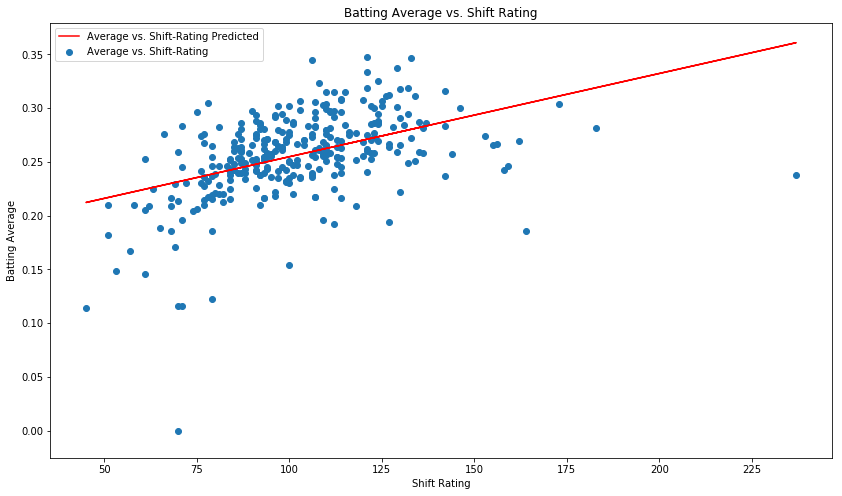

In [311]:
shift_x = list(batters['sr_total'])
avg_y = list(batters['avg'])

Sy = batters["avg"].std()
Sx = batters["sr_total"].std()
m = tot_avg_r * (Sy / Sx)
b = batters['avg'].mean() - (m * batters['sr_total'].mean())
y = m * batters['sr_total'].copy() + b

fig, ax = plt.subplots(figsize=(14,8))
plt.scatter(shift_x, avg_y, label='Average vs. Shift-Rating')
plt.plot(shift_x, y, color='red', label='Average vs. Shift-Rating Predicted')
plt.title("Batting Average vs. Shift Rating")
plt.xlabel("Shift Rating")
plt.ylabel("Batting Average")
plt.legend()
print("R-squared: {:.3f}".format(tot_avg_r**2))

R-squared: 0.064


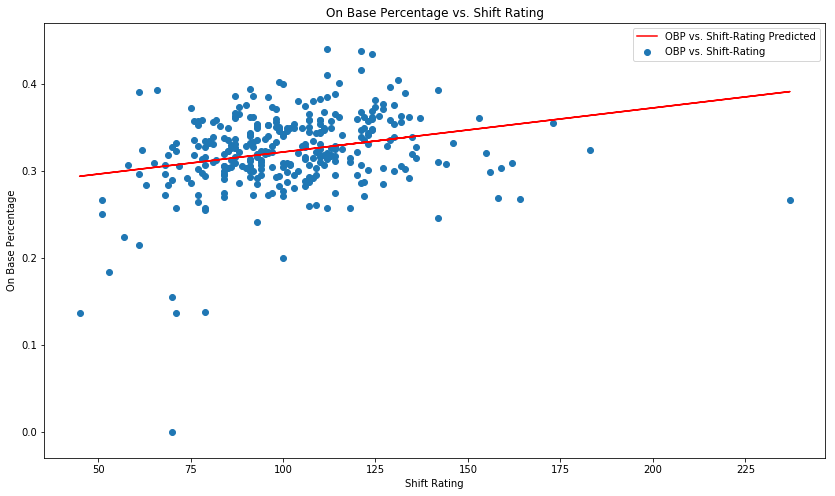

In [310]:
shift_x = list(batters['sr_total'])
obp_y = list(batters['obp'])

Sy = batters["obp"].std()
Sx = batters["sr_total"].std()
m = tot_obp_r * (Sy / Sx)
b = batters['obp'].mean() - (m * batters['sr_total'].mean())
y = m * batters['sr_total'].copy() + b

fig, ax = plt.subplots(figsize=(14,8))
plt.scatter(shift_x, obp_y, label='OBP vs. Shift-Rating')
plt.plot(shift_x, y, color='red', label='OBP vs. Shift-Rating Predicted')
plt.title("On Base Percentage vs. Shift Rating")
plt.xlabel("Shift Rating")
plt.ylabel("On Base Percentage")
plt.legend()
print("R-squared: {:.3f}".format(tot_obp_r**2))